# Experiments on Hypergraph construction

In [ ]:
import time
import os
from copy import deepcopy

import json
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


import dhg
from dhg import Graph, Hypergraph
from dhg.data import Cooking200, News20
from dhg.models import GCN, HGNN, HGNNP, HNHN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
from dhg.utils import split_by_ratio

from typing import Optional, Dict, Any, List

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval
from itertools import combinations

In [216]:
set_seed(42)

print(dhg.CACHE_ROOT)
print(os.getcwd())

C:\Users\rustem_izmailov\.dhg
d:\Rustem\2_Education\9_UWindsor_CSS\COMP_8720-Topics_in_AI\project\hyper_modeling


## 1. DHG

In [ ]:
# d=dhg.data.Cooking200()
# for key in d.content:
#     d[key]

In [308]:
def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res

### Cooking200

In [ ]:
data_path = r'.\datasets\dhg_datasets'
data = Cooking200(data_path)

if not 'train_mask' in data.content:
    train_mask, test_mask, val_mask = split_by_ratio(
        num_v = data["num_vertices"],
        v_label = data["labels"],
        train_ratio = 0.6,
        test_ratio = 0.2,
        val_ratio = 0.2
        )

    data._content.update({"train_mask": train_mask, "test_mask": test_mask, "val_mask": val_mask})

data

#### GCN

In [283]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
ft_dim = X.shape[1]
HG = Hypergraph(data["num_vertices"], data["edge_list"])
G = Graph.from_hypergraph_clique(HG, weighted=True)
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = GCN(ft_dim, 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 27.05090s, Loss: 3.00726
update best: 0.05000
Epoch: 1, Time: 1.11877s, Loss: 2.87365
Epoch: 2, Time: 0.97288s, Loss: 2.63956
update best: 0.09500
Epoch: 3, Time: 0.97195s, Loss: 2.46788
Epoch: 4, Time: 0.95451s, Loss: 2.36260
Epoch: 5, Time: 0.97938s, Loss: 2.28780
update best: 0.13000
Epoch: 6, Time: 1.09381s, Loss: 2.21204
update best: 0.13500
Epoch: 7, Time: 0.93865s, Loss: 2.13388
Epoch: 8, Time: 1.13131s, Loss: 2.06262
update best: 0.14000
Epoch: 9, Time: 1.40688s, Loss: 1.99684
Epoch: 10, Time: 1.38883s, Loss: 1.91773
Epoch: 11, Time: 1.27973s, Loss: 1.84279
Epoch: 12, Time: 1.31780s, Loss: 1.76692
Epoch: 13, Time: 1.21678s, Loss: 1.69607
Epoch: 14, Time: 1.50236s, Loss: 1.62226
Epoch: 15, Time: 1.37457s, Loss: 1.55436
Epoch: 16, Time: 1.23136s, Loss: 1.48475
Epoch: 17, Time: 1.41042s, Loss: 1.41734
Epoch: 18, Time: 1.25632s, Loss: 1.34714
Epoch: 19, Time: 1.30601s, Loss: 1.27656
update best: 0.16500
Epoch: 20, Time: 1.20952s, Loss: 1.20234
Epoch: 21, Time: 1.190

#### HGNN

In [218]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 1.27188s, Loss: 3.00386
update best: 0.05000
Epoch: 1, Time: 1.54415s, Loss: 2.70985
Epoch: 2, Time: 1.50128s, Loss: 2.37330
Epoch: 3, Time: 1.81600s, Loss: 2.18877
Epoch: 4, Time: 1.50025s, Loss: 2.05079
Epoch: 5, Time: 1.49115s, Loss: 1.92147
Epoch: 6, Time: 1.39025s, Loss: 1.80867
update best: 0.09000
Epoch: 7, Time: 1.39048s, Loss: 1.68405
update best: 0.09500
Epoch: 8, Time: 1.40198s, Loss: 1.55780
Epoch: 9, Time: 1.32872s, Loss: 1.45725
Epoch: 10, Time: 1.33453s, Loss: 1.36144
Epoch: 11, Time: 1.98168s, Loss: 1.23599
Epoch: 12, Time: 1.50997s, Loss: 1.14826
Epoch: 13, Time: 1.64627s, Loss: 1.03714
Epoch: 14, Time: 1.72242s, Loss: 0.94961
update best: 0.10000
Epoch: 15, Time: 1.53512s, Loss: 0.87812
update best: 0.10500
Epoch: 16, Time: 1.35259s, Loss: 0.79208
Epoch: 17, Time: 1.35914s, Loss: 0.72543
Epoch: 18, Time: 1.38262s, Loss: 0.65884
Epoch: 19, Time: 1.37241s, Loss: 0.59730
Epoch: 20, Time: 1.41043s, Loss: 0.55186
Epoch: 21, Time: 1.45364s, Loss: 0.48377
Epo

#### HGNN+

In [223]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNNP(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.10855s, Loss: 3.00464
update best: 0.05000
Epoch: 1, Time: 0.08103s, Loss: 2.85373
Epoch: 2, Time: 0.09561s, Loss: 2.39547
Epoch: 3, Time: 0.08431s, Loss: 2.16992
Epoch: 4, Time: 0.08556s, Loss: 1.98238
Epoch: 5, Time: 0.08011s, Loss: 1.82536
update best: 0.07500
Epoch: 6, Time: 0.09422s, Loss: 1.69112
update best: 0.08000
Epoch: 7, Time: 0.08904s, Loss: 1.55686
Epoch: 8, Time: 0.09059s, Loss: 1.43632
update best: 0.11000
Epoch: 9, Time: 0.07604s, Loss: 1.31332
update best: 0.22000
Epoch: 10, Time: 0.08363s, Loss: 1.20795
Epoch: 11, Time: 0.07904s, Loss: 1.09272
Epoch: 12, Time: 0.07904s, Loss: 1.00381
Epoch: 13, Time: 0.14408s, Loss: 0.90282
Epoch: 14, Time: 0.08704s, Loss: 0.81816
Epoch: 15, Time: 0.07804s, Loss: 0.74913
Epoch: 16, Time: 0.08156s, Loss: 0.66262
Epoch: 17, Time: 0.08205s, Loss: 0.60239
Epoch: 18, Time: 0.11778s, Loss: 0.53853
Epoch: 19, Time: 0.09161s, Loss: 0.48864
Epoch: 20, Time: 0.09068s, Loss: 0.42724
Epoch: 21, Time: 0.08355s, Loss: 0.38623
Epo

### Co-citation Citaseer

In [313]:
data_path = r'.\datasets\dhg_datasets'
data = dhg.data.CocitationCiteseer(data_path)

if not 'train_mask' in data.content:
    train_mask, test_mask, val_mask = split_by_ratio(
        num_v = data["num_vertices"],
        v_label = data["labels"],
        train_ratio = 0.6,
        test_ratio = 0.2,
        val_ratio = 0.2
        )

    data._content.update({"train_mask": train_mask, "test_mask": test_mask, "val_mask": val_mask})

data

This is cocitation_citeseer dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.

In [315]:
display(data['num_vertices'])
data['num_edges']

3312

1079

#### GCN

In [279]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
ft_dim = X.shape[1]
HG = Hypergraph(data["num_vertices"], data["edge_list"])
G = Graph.from_hypergraph_clique(HG, weighted=True)
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = GCN(ft_dim, 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.07557s, Loss: 1.84384
update best: 0.18053
Epoch: 1, Time: 0.01852s, Loss: 1.32729
Epoch: 2, Time: 0.02073s, Loss: 0.89455
Epoch: 3, Time: 0.01821s, Loss: 0.58217
Epoch: 4, Time: 0.02025s, Loss: 0.33297
Epoch: 5, Time: 0.01954s, Loss: 0.21457
Epoch: 6, Time: 0.01855s, Loss: 0.16569
update best: 0.18399
Epoch: 7, Time: 0.01419s, Loss: 0.11529
update best: 0.20258
Epoch: 8, Time: 0.02618s, Loss: 0.11493
update best: 0.21928
Epoch: 9, Time: 0.02598s, Loss: 0.08893
update best: 0.22716
Epoch: 10, Time: 0.01781s, Loss: 0.04256
update best: 0.23503
Epoch: 11, Time: 0.01740s, Loss: 0.05914
update best: 0.24071
Epoch: 12, Time: 0.01607s, Loss: 0.03737
update best: 0.24354
Epoch: 13, Time: 0.01743s, Loss: 0.03301
update best: 0.25457
Epoch: 14, Time: 0.01613s, Loss: 0.02690
update best: 0.25772
Epoch: 15, Time: 0.01786s, Loss: 0.01817
update best: 0.25835
Epoch: 16, Time: 0.01224s, Loss: 0.04195
Epoch: 17, Time: 0.01985s, Loss: 0.04121
Epoch: 18, Time: 0.02273s, Loss: 0.01221


#### HGNN

In [280]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.02666s, Loss: 1.81649
update best: 0.21424
Epoch: 1, Time: 0.02883s, Loss: 1.43765
update best: 0.21865
Epoch: 2, Time: 0.02005s, Loss: 1.22796
Epoch: 3, Time: 0.01828s, Loss: 1.15794
Epoch: 4, Time: 0.01936s, Loss: 1.12441
update best: 0.22023
Epoch: 5, Time: 0.02366s, Loss: 1.10783
update best: 0.22275
Epoch: 6, Time: 0.01793s, Loss: 1.09250
update best: 0.22369
Epoch: 7, Time: 0.02164s, Loss: 1.08502
update best: 0.22495
Epoch: 8, Time: 0.02327s, Loss: 1.07616
update best: 0.22527
Epoch: 9, Time: 0.02244s, Loss: 1.07437
Epoch: 10, Time: 0.01950s, Loss: 1.07368
update best: 0.22590
Epoch: 11, Time: 0.01640s, Loss: 1.06851
Epoch: 12, Time: 0.01686s, Loss: 1.06937
Epoch: 13, Time: 0.01804s, Loss: 1.07050
Epoch: 14, Time: 0.01849s, Loss: 1.06823
update best: 0.22684
Epoch: 15, Time: 0.02724s, Loss: 1.06642
update best: 0.22810
Epoch: 16, Time: 0.04121s, Loss: 1.06693
update best: 0.22842
Epoch: 17, Time: 0.01856s, Loss: 1.06795
update best: 0.22873
Epoch: 18, Time: 0.0

#### HGNN+

In [281]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

X, lbl = torch.eye(data["num_vertices"]), data["labels"]
G = Hypergraph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = HGNNP(X.shape[1], 32, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
for epoch in range(200):
    # train
    train(net, X, G, lbl, train_mask, optimizer, epoch)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

Epoch: 0, Time: 0.04270s, Loss: 1.82284
update best: 0.21361
Epoch: 1, Time: 0.02071s, Loss: 1.51886
Epoch: 2, Time: 0.02244s, Loss: 1.30142
Epoch: 3, Time: 0.01422s, Loss: 1.19327
Epoch: 4, Time: 0.01827s, Loss: 1.14901
update best: 0.21456
Epoch: 5, Time: 0.01704s, Loss: 1.11603
update best: 0.21582
Epoch: 6, Time: 0.01643s, Loss: 1.09219
update best: 0.21676
Epoch: 7, Time: 0.01922s, Loss: 1.08688
Epoch: 8, Time: 0.02138s, Loss: 1.08081
update best: 0.21802
Epoch: 9, Time: 0.02001s, Loss: 1.07927
update best: 0.21991
Epoch: 10, Time: 0.02502s, Loss: 1.07121
update best: 0.22401
Epoch: 11, Time: 0.01725s, Loss: 1.07070
update best: 0.22842
Epoch: 12, Time: 0.01808s, Loss: 1.06910
update best: 0.23220
Epoch: 13, Time: 0.01767s, Loss: 1.06739
update best: 0.23756
Epoch: 14, Time: 0.01468s, Loss: 1.06867
update best: 0.24228
Epoch: 15, Time: 0.02318s, Loss: 1.06965
update best: 0.24890
Epoch: 16, Time: 0.01846s, Loss: 1.06565
update best: 0.25488
Epoch: 17, Time: 0.02093s, Loss: 1.06624

### Experiments

In [312]:
# import time
# import os
# from copy import deepcopy

# import torch
# import torch.optim as optim
# import torch.nn.functional as F

# import dhg
# from dhg import Graph, Hypergraph
# from dhg.data import Cooking200, News20
# from dhg.models import GCN, HGNN, HGNNP, HNHN
# from dhg.random import set_seed
# from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
# from dhg.utils import split_by_ratio

set_seed(42)


def get_top_k_densest_subgraphs(hg: Hypergraph, k: int = 3) -> list:
    """Find top-k densest subgraphs using greedy approximation"""
    nodes = set(range(hg.num_v))
    subgraphs = []
    
    for _ in range(k):
        if len(nodes) < 3:  # min_size
            break
            
        current_nodes = set(nodes)
        best_subset = None
        best_density = -1
        
        while len(current_nodes) >= 3:
            edge_count = sum(1 for e in hg.e[0] if set(e).issubset(current_nodes))
            density = edge_count / len(current_nodes)
            
            if density > best_density:
                best_density = density
                best_subset = set(current_nodes)
            
            # Remove node with lowest degree
            degrees = {v: sum(v in e for e in hg.e[0]) for v in current_nodes}
            node_to_remove = min(degrees.items(), key=lambda x: x[1])[0]
            current_nodes.remove(node_to_remove)
        
        if best_subset:
            subgraphs.append((best_subset, best_density))
            nodes -= best_subset
    
    return subgraphs

def preprocess_hypergraph_with_topk(hg: Hypergraph, k: int = 3) -> Hypergraph:
    """Preprocess hypergraph by focusing on top-k densest subgraphs"""
    subgraphs = get_top_k_densest_subgraphs(hg, k)
    if not subgraphs:
        return hg
    
    # Combine all nodes from top-k subgraphs
    important_nodes = set()
    for subset, _ in subgraphs:
        important_nodes.update(subset)
    
    # Create new hypergraph with only important edges
    new_edges = []
    for e in hg.e[0]:
        if set(e).issubset(important_nodes):
            new_edges.append(e)
    
    return Hypergraph(hg.num_v, new_edges)

def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()

@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res

def run_experiment(use_topk=False, k=3):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    
    if use_topk:
        print(f"Using Top-{k} Densest Subgraphs preprocessing")
        G = preprocess_hypergraph_with_topk(G, k)
    else:
        print("Using original hypergraph (no Top-k preprocessing)")
    
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)
    net = net.to(device)

    best_state = None
    best_epoch, best_val = 0, 0
    for epoch in range(200):
        # train
        train(net, X, G, lbl, train_mask, optimizer, epoch)
        # validation
        if epoch % 1 == 0:
            with torch.no_grad():
                val_res = infer(net, X, G, lbl, val_mask)
            if val_res > best_val:
                print(f"update best: {val_res:.5f}")
                best_epoch = epoch
                best_val = val_res
                best_state = deepcopy(net.state_dict())
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")
    # test
    print("test...")
    net.load_state_dict(best_state)
    res = infer(net, X, G, lbl, test_mask, test=True)
    print(f"final result: epoch: {best_epoch}")
    print(res)
    return res

# Run experiments
print("=== Baseline Experiment (No Top-k) ===")
baseline_results = run_experiment(use_topk=False)

print("\n=== Experiment with Top-k Densest Subgraphs ===")
topk_results = run_experiment(use_topk=True, k=3)

# Compare results
print("\n=== Comparison of Results ===")
print(f"Baseline performance: {baseline_results}")
print(f"Top-k performance: {topk_results}")

=== Baseline Experiment (No Top-k) ===
Using original hypergraph (no Top-k preprocessing)
Epoch: 0, Time: 0.06937s, Loss: 1.84667
update best: 0.21014
Epoch: 1, Time: 0.03478s, Loss: 1.56151
Epoch: 2, Time: 0.02969s, Loss: 1.32516
update best: 0.21361
Epoch: 3, Time: 0.04779s, Loss: 1.21602
update best: 0.21960
Epoch: 4, Time: 0.02403s, Loss: 1.15841
update best: 0.22023
Epoch: 5, Time: 0.01888s, Loss: 1.12637
Epoch: 6, Time: 0.01813s, Loss: 1.11725
Epoch: 7, Time: 0.01915s, Loss: 1.10174
Epoch: 8, Time: 0.01913s, Loss: 1.10152
Epoch: 9, Time: 0.01982s, Loss: 1.08360
update best: 0.22054
Epoch: 10, Time: 0.01888s, Loss: 1.07704
update best: 0.22149
Epoch: 11, Time: 0.01946s, Loss: 1.07767
Epoch: 12, Time: 0.01809s, Loss: 1.07627
update best: 0.22180
Epoch: 13, Time: 0.01632s, Loss: 1.07444
update best: 0.22243
Epoch: 14, Time: 0.02069s, Loss: 1.07337
update best: 0.22369
Epoch: 15, Time: 0.01838s, Loss: 1.07144
update best: 0.22464
Epoch: 16, Time: 0.02056s, Loss: 1.06839
update best: 

## 2. Movies

In [84]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/movies-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.13M/5.13M [00:00<00:00, 23.3MB/s]

Extracting model files...
Path to dataset files: C:\Users\rustem_izmailov\.cache\kagglehub\datasets\utkarshx27\movies-dataset\versions\1


In [317]:
movie_path = r'.\datasets\movie\movie_dataset.csv'

In [318]:
df = pd.read_csv(movie_path)

In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [320]:
df.genres.head(5)

0    Action Adventure Fantasy Science Fiction
1                    Adventure Fantasy Action
2                      Action Adventure Crime
3                 Action Crime Drama Thriller
4            Action Adventure Science Fiction
Name: genres, dtype: object

### Experiments

In [321]:
class HypergraphExperiment:
    def __init__(self, data_path: str):
        self.data_path = data_path
        self.results = []
        
    def run_experiments(self, n_samples=500):
        """Запускает все варианты экспериментов"""
        # 1. Базовый гиперграф (без плотных подграфов)
        print("\n=== Experiment 1: Base Hypergraph ===")
        base_data = MovieHypergraphDataset(
            data_root=self.data_path,
            n_samples=n_samples,
            use_densest_subgraphs=False
        )
        base_results = self._train_and_evaluate(base_data)
        self.results.append(("Base", base_results))
        
        # 2. С топ-k плотными подграфами
        print("\n=== Experiment 2: With Densest Subgraphs ===")
        dense_data = MovieHypergraphDataset(
            data_root=self.data_path,
            n_samples=n_samples,
            use_densest_subgraphs=True,
            k=5
        )
        dense_results = self._train_and_evaluate(dense_data)
        self.results.append(("With Densest Subgraphs", dense_results))
        
        # 3. Только жанровые гиперребра
        print("\n=== Experiment 3: Genre-Only Hypergraph ===")
        genre_data = MovieHypergraphDataset(
            data_root=self.data_path,
            n_samples=n_samples,
            hyperedge_types=["genre"]
        )
        genre_results = self._train_and_evaluate(genre_data)
        self.results.append(("Genre-Only", genre_results))
        
        # Визуализация результатов
        self._visualize_results()

    def _train_and_evaluate(self, data) -> Dict[str, float]:
        """Обучает модели и возвращает результаты"""
        # Get all the data we need
        X = data["features"]
        lbl = data["labels"]
        edge_list = data["edge_list"]
        num_vertices = data["num_vertices"]
        train_mask = data["train_mask"]
        val_mask = data["val_mask"]
        test_mask = data["test_mask"]
        num_classes = data["num_classes"]
        
        # Check if edge_list is empty
        if not edge_list:
            print("Warning: Empty edge list! Creating a fallback edge list based on nearest neighbors.")
            # Create a fallback edge list using k-nearest neighbors
            from sklearn.neighbors import NearestNeighbors
            knn = NearestNeighbors(n_neighbors=5).fit(X.numpy())
            _, indices = knn.kneighbors(X.numpy())
            edge_list = [list(idx) for idx in indices]
        
        # Now use the potentially updated edge_list
        hg = Hypergraph(num_vertices, edge_list)
        masks = {
            "train": train_mask,
            "val": val_mask,
            "test": test_mask
        }
        
        models = {
            "HGNN": HGNN(X.shape[1], 64, num_classes),
            "HGNNP": HGNNP(X.shape[1], 64, num_classes, use_bn=True),
        }
        
        results = {}
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model = model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            
            best_val = 0
            for epoch in range(100):
                train(model, X, hg, lbl, masks["train"], optimizer, epoch)
                
                if epoch % 5 == 0:
                    val_res = infer(model, X, hg, lbl, masks["val"])
                    # Extract the accuracy value from the dictionary
                    val_accuracy = val_res.get('accuracy', 0)  # Assuming accuracy is the key
                    if val_accuracy > best_val:
                        best_val = val_accuracy
            
            test_res = infer(model, X, hg, lbl, masks["test"], test=True)
            results[name] = {
                "val_accuracy": best_val,
                "test_accuracy": test_res.get('accuracy', 0)  # Also extract accuracy
            }
        
        return results

    def _visualize_results(self):
        """Визуализирует сравнение экспериментов"""
        df = pd.DataFrame({
            "Experiment": [exp[0] for exp in self.results],
            "HGNN Val": [exp[1]["HGNN"]["val_accuracy"] for exp in self.results],
            "HGNN Test": [exp[1]["HGNN"]["test_accuracy"] for exp in self.results],
            "HGNNP Val": [exp[1]["HGNNP"]["val_accuracy"] for exp in self.results],
            "HGNNP Test": [exp[1]["HGNNP"]["test_accuracy"] for exp in self.results]
        })
        
        plt.figure(figsize=(12, 6))
        ax = df.plot(
            x="Experiment",
            y=["HGNN Val", "HGNN Test", "HGNNP Val", "HGNNP Test"],
            kind="bar",
            rot=45
        )
        plt.title("Comparison of Hypergraph Construction Methods")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.savefig("hypergraph_comparison.png")
        plt.show()
        
        print("\n=== Results Summary ===")
        print(df.to_string(index=False))

In [322]:
class MovieHypergraphDataset:
    def __init__(
        self,
        data_root: str,
        n_samples: Optional[int] = None,
        use_densest_subgraphs: bool = False,
        k: int = 3,
        hyperedge_types: List[str] = ["genre", "director", "numerical"]
    ):
        self.data_root = data_root
        self.n_samples = n_samples
        self.use_densest_subgraphs = use_densest_subgraphs
        self.k = k
        self.hyperedge_types = hyperedge_types
        self._content = self._build_dataset()

    def _build_dataset(self) -> Dict[str, Any]:
        """Build the complete dataset dictionary"""
        # Load and preprocess data
        df = pd.read_csv(self.data_root)
        if self.n_samples:
            df = df.sample(min(self.n_samples, len(df)))

        df = self._preprocess_data(df)
        
        # Create features and labels
        features = self._create_features(df)
        labels = (df['revenue'] > df['budget']).astype(int).values
        
        # Create splits
        train_mask, val_mask, test_mask = self._create_splits(labels)
        
        # Create hyperedges
        edge_list = self._create_hyperedges(df)
        
        # Add densest subgraphs if enabled
        if self.use_densest_subgraphs and len(edge_list) > 0:
            temp_hg = Hypergraph(len(df), edge_list)
            top_k_subgraphs = self._get_top_k_densest_subgraphs(temp_hg, k=self.k)
            edge_list.extend([list(subset) for subset, _ in top_k_subgraphs])
        
        return {
            "num_classes": 2,
            "num_vertices": len(df),
            "num_edges": len(edge_list),
            "features": torch.FloatTensor(features),
            "labels": torch.LongTensor(labels),
            "edge_list": edge_list,
            "train_mask": train_mask,
            "val_mask": val_mask,
            "test_mask": test_mask,
        }

    def _preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and preprocess the raw data"""
        # Convert stringified lists to actual lists
        for col in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
            if col in df.columns:
                df[col] = df[col].apply(
                    lambda x: literal_eval(x) 
                    if pd.notna(x) and isinstance(x, str) and x.startswith('[') 
                    else []
                )
        
        # Handle genres specially if they're space-separated strings
        if 'genres' in df.columns:
            df['genres'] = df['genres'].apply(
                lambda x: [{'name': g.strip()} for g in x.split()] 
                if pd.notna(x) and isinstance(x, str) and not x.startswith('[')
                else x
            )
        
        # Fill missing values
        text_cols = ['overview', 'tagline', 'director']
        for col in text_cols:
            if col in df.columns:
                df[col] = df[col].fillna('')
        
        num_cols = ['runtime', 'budget', 'revenue', 'popularity', 'vote_average', 'vote_count']
        for col in num_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())
        
        return df

    def _create_features(self, df: pd.DataFrame) -> np.ndarray:
        """Create feature matrix combining numerical and text features"""
        # Numerical features
        num_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
        X_num = StandardScaler().fit_transform(df[num_features].values) if num_features else np.zeros((len(df), 0))
        
        # Text features from overview
        tfidf = TfidfVectorizer(max_features=200, stop_words='english')
        X_text = tfidf.fit_transform(df['overview']).toarray() if 'overview' in df.columns else np.zeros((len(df), 0))
        
        return np.concatenate([X_num, X_text], axis=1)

    def _create_splits(self, labels: np.ndarray) -> tuple:
        """Create train/val/test splits with stratification"""
        indices = np.arange(len(labels))
        train_idx, test_idx = train_test_split(indices, test_size=0.3, stratify=labels)
        val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx])
        
        train_mask = torch.zeros(len(labels), dtype=torch.bool)
        val_mask = torch.zeros(len(labels), dtype=torch.bool)
        test_mask = torch.zeros(len(labels), dtype=torch.bool)
        
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        
        return train_mask, val_mask, test_mask

    def _create_hyperedges(self, df: pd.DataFrame) -> list:
        """Create hyperedges based on specified types"""
        edge_list = []
        
        if "genre" in self.hyperedge_types and 'genres' in df.columns:
            genre_to_movies = {}
            for idx, genres in enumerate(df['genres']):
                if isinstance(genres, list):
                    for genre in genres:
                        name = genre['name'] if isinstance(genre, dict) else genre
                        if name not in genre_to_movies:
                            genre_to_movies[name] = []
                        genre_to_movies[name].append(idx)
            edge_list.extend(list(genre_to_movies.values()))
        
        if "director" in self.hyperedge_types and 'director' in df.columns:
            director_to_movies = {}
            for idx, director in enumerate(df['director']):
                if pd.notna(director):
                    if director not in director_to_movies:
                        director_to_movies[director] = []
                    director_to_movies[director].append(idx)
            edge_list.extend(list(director_to_movies.values()))
        
        if "numerical" in self.hyperedge_types:
            numerical_features = ['budget', 'popularity', 'runtime', 'vote_average']
            X_num = df[numerical_features].values
            knn = NearestNeighbors(n_neighbors=5).fit(X_num)
            _, indices = knn.kneighbors(X_num)
            edge_list.extend([list(idx) for idx in indices])
        
        return edge_list

    def _get_top_k_densest_subgraphs(self, hg: Hypergraph, k: int = 3) -> list:
        """Find top-k densest subgraphs using greedy approximation"""
        nodes = set(range(hg.num_v))
        subgraphs = []
        
        for _ in range(k):
            if len(nodes) < 3:  # min_size
                break
                
            current_nodes = set(nodes)
            best_subset = None
            best_density = -1
            
            while len(current_nodes) >= 3:
                edge_count = sum(1 for e in hg.e[0] if set(e).issubset(current_nodes))
                density = edge_count / len(current_nodes)
                
                if density > best_density:
                    best_density = density
                    best_subset = set(current_nodes)
                
                # Remove node with lowest degree
                degrees = {v: sum(v in e for e in hg.e[0]) for v in current_nodes}
                node_to_remove = min(degrees.items(), key=lambda x: x[1])[0]
                current_nodes.remove(node_to_remove)
            
            if best_subset:
                subgraphs.append((best_subset, best_density))
                nodes -= best_subset
        
        return subgraphs

    def __getitem__(self, key):
        return self._content[key]

In [323]:
def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.item():.5f}")
    return loss.item()

@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    
    # Handle both cases: when evaluator returns dict or float
    if isinstance(res, dict):
        return res
    else:
        # If single float returned, assume it's accuracy
        return {'accuracy': res, 'f1_score': res}  # Using same value for both for compatibility

def evaluate_model(model, hypergraph_type, X, hg, labels, masks):
    results = {}
    for name, mask in masks.items():
        res = infer(model, X, hg, labels, mask, test=(name == "test"))
        results[f"{hypergraph_type}_{name}"] = res
    return results


=== Experiment 1: Base Hypergraph ===


C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_1216\2834835554.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  lambda x: [{'name': g.strip()} for g in x.split()]



Training HGNN...
Epoch: 0, Loss: 0.69112
Epoch: 1, Loss: 0.66235
Epoch: 2, Loss: 0.63524
Epoch: 3, Loss: 0.61238
Epoch: 4, Loss: 0.58599
Epoch: 5, Loss: 0.55757
Epoch: 6, Loss: 0.54222
Epoch: 7, Loss: 0.51972
Epoch: 8, Loss: 0.51287
Epoch: 9, Loss: 0.50268
Epoch: 10, Loss: 0.48778
Epoch: 11, Loss: 0.47216
Epoch: 12, Loss: 0.46113
Epoch: 13, Loss: 0.46434
Epoch: 14, Loss: 0.44284
Epoch: 15, Loss: 0.44244
Epoch: 16, Loss: 0.42341
Epoch: 17, Loss: 0.41219
Epoch: 18, Loss: 0.41091
Epoch: 19, Loss: 0.39324
Epoch: 20, Loss: 0.39751
Epoch: 21, Loss: 0.39395
Epoch: 22, Loss: 0.38533
Epoch: 23, Loss: 0.38006
Epoch: 24, Loss: 0.37904
Epoch: 25, Loss: 0.36347
Epoch: 26, Loss: 0.36947
Epoch: 27, Loss: 0.35982
Epoch: 28, Loss: 0.35105
Epoch: 29, Loss: 0.36140
Epoch: 30, Loss: 0.34777
Epoch: 31, Loss: 0.34356
Epoch: 32, Loss: 0.32708
Epoch: 33, Loss: 0.33521
Epoch: 34, Loss: 0.32863
Epoch: 35, Loss: 0.32771
Epoch: 36, Loss: 0.32651
Epoch: 37, Loss: 0.31124
Epoch: 38, Loss: 0.31586
Epoch: 39, Loss: 

C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_1216\2834835554.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  lambda x: [{'name': g.strip()} for g in x.split()]



Training HGNN...
Epoch: 0, Loss: 0.70098
Epoch: 1, Loss: 0.68442
Epoch: 2, Loss: 0.66562
Epoch: 3, Loss: 0.64448
Epoch: 4, Loss: 0.63101
Epoch: 5, Loss: 0.61375
Epoch: 6, Loss: 0.59395
Epoch: 7, Loss: 0.58731
Epoch: 8, Loss: 0.56950
Epoch: 9, Loss: 0.55366
Epoch: 10, Loss: 0.54611
Epoch: 11, Loss: 0.54058
Epoch: 12, Loss: 0.53113
Epoch: 13, Loss: 0.51910
Epoch: 14, Loss: 0.50516
Epoch: 15, Loss: 0.49548
Epoch: 16, Loss: 0.48825
Epoch: 17, Loss: 0.48405
Epoch: 18, Loss: 0.46224
Epoch: 19, Loss: 0.45427
Epoch: 20, Loss: 0.44806
Epoch: 21, Loss: 0.43104
Epoch: 22, Loss: 0.41930
Epoch: 23, Loss: 0.42311
Epoch: 24, Loss: 0.41357
Epoch: 25, Loss: 0.41387
Epoch: 26, Loss: 0.40375
Epoch: 27, Loss: 0.39132
Epoch: 28, Loss: 0.39232
Epoch: 29, Loss: 0.37448
Epoch: 30, Loss: 0.36941
Epoch: 31, Loss: 0.37298
Epoch: 32, Loss: 0.38386
Epoch: 33, Loss: 0.36346
Epoch: 34, Loss: 0.34633
Epoch: 35, Loss: 0.34583
Epoch: 36, Loss: 0.36542
Epoch: 37, Loss: 0.33314
Epoch: 38, Loss: 0.33390
Epoch: 39, Loss: 

C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_1216\2834835554.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  lambda x: [{'name': g.strip()} for g in x.split()]



Training HGNN...
Epoch: 0, Loss: 0.70138
Epoch: 1, Loss: 0.66480
Epoch: 2, Loss: 0.63156
Epoch: 3, Loss: 0.60616
Epoch: 4, Loss: 0.57182
Epoch: 5, Loss: 0.55546
Epoch: 6, Loss: 0.54255
Epoch: 7, Loss: 0.52450
Epoch: 8, Loss: 0.51574
Epoch: 9, Loss: 0.51963
Epoch: 10, Loss: 0.50523
Epoch: 11, Loss: 0.51114
Epoch: 12, Loss: 0.49880
Epoch: 13, Loss: 0.49176
Epoch: 14, Loss: 0.48970
Epoch: 15, Loss: 0.48529
Epoch: 16, Loss: 0.48184
Epoch: 17, Loss: 0.48338
Epoch: 18, Loss: 0.47569
Epoch: 19, Loss: 0.48052
Epoch: 20, Loss: 0.47274
Epoch: 21, Loss: 0.47735
Epoch: 22, Loss: 0.46514
Epoch: 23, Loss: 0.46843
Epoch: 24, Loss: 0.46633
Epoch: 25, Loss: 0.46006
Epoch: 26, Loss: 0.45575
Epoch: 27, Loss: 0.45750
Epoch: 28, Loss: 0.45252
Epoch: 29, Loss: 0.45226
Epoch: 30, Loss: 0.44903
Epoch: 31, Loss: 0.44452
Epoch: 32, Loss: 0.43981
Epoch: 33, Loss: 0.44432
Epoch: 34, Loss: 0.44382
Epoch: 35, Loss: 0.43623
Epoch: 36, Loss: 0.44027
Epoch: 37, Loss: 0.42530
Epoch: 38, Loss: 0.43454
Epoch: 39, Loss: 

<Figure size 1200x600 with 0 Axes>

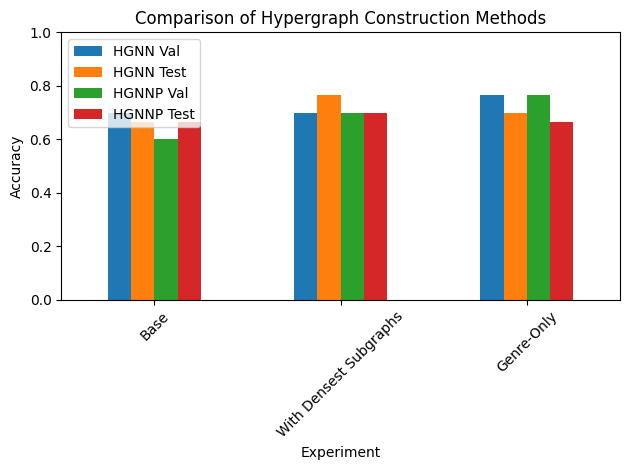


=== Results Summary ===
            Experiment  HGNN Val  HGNN Test  HGNNP Val  HGNNP Test
                  Base  0.700000   0.666667   0.600000    0.666667
With Densest Subgraphs  0.700000   0.766667   0.700000    0.700000
            Genre-Only  0.766667   0.700000   0.766667    0.666667


In [324]:
movie_path = r'.\datasets\movie\movie_dataset.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

experiment = HypergraphExperiment(
    data_path=movie_path
)
experiment.run_experiments(n_samples=200)